In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt
import pprint

sys.path.append('../src/')
from env import BTCMarket_Env
# from agent import Trader_Agent
# from DQNtrainer import DQNTrainer
# from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product

import agent as TAgent
import env as BTCEnv
import DQNtrainer as DQNTrainer
import DRLtrainer as DRLTrainer

from importlib import reload 


In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_logical_device_configuration(
#         physical_devices[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Preparations

In [39]:
data_source_btc = "BTC_histData_dt1800.0s_20220825_0629" 
data_source_perp = "Perp_BTC_FundingRate_Data_fakehist"

hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC'],
#     'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
#                         'reward_differential_sharpe_ratio', 'reward_profit'],
    'reward_function' : ['reward_profit'],
    
    'learning_rate': [1e-3],
#     'trainer' : ['DRLTrainer.DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'trainer' : ['DQNTrainer.DQNTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [1], 
    'batch_size': [50],
    'epoch': [1],
    'gamma': [0.95],
    
    'epsilon': [0.5],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
pprint.pprint(hpo_list)

[{'action_domain': (0.0, 1.0),
  'asset': 'BTC',
  'batch_size': 50,
  'episodes': 1,
  'epoch': 1,
  'epsilon': 0.5,
  'epsilon_decay': 0.995,
  'epsilon_final': 0.01,
  'fee': 0.001,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'money': 10000,
  'obs_space': (8, 20),
  'reward_function': 'reward_profit',
  'runs_p_eps': 1,
  'trainer': 'DQNTrainer.DQNTrainer'}]


In [40]:
TAgent=reload(TAgent)
BTCEnv=reload(BTCEnv)
DQNTrainer=reload(DQNTrainer)
DRLTrainer=reload(DRLTrainer)

In [41]:
def conduct_traning(param_combination, i):
    if param_combination.get('trainer') == 'DQNTrainer.DQNTrainer':
        action_space = 4
        algorithm = f'DQN_trial_{i}'
    else:
        action_space = 1
        algorithm = f'DRL_trial_{i}'

    if param_combination.get('asset') == 'BTC':
        param_combination["data_source"] = data_source_btc
    else:
        param_combination["data_source"] = data_source_perp


    param_combination['action_space'] = action_space
    param_combination['algorithm'] = algorithm
    pprint.pprint(param_combination)

    env = BTCEnv.BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            start_money = param_combination.get('money', 10000),
            trading_fee = param_combination.get('fee', 0.001),
            asset = param_combination.get('asset', 'BTC'),
            source_file = param_combination.get('data_source', data_source_btc),
            reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                       )

    agent = TAgent.Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                action_domain = param_combination.get('action_domain', (0.0,1.0)),
                epsilon = param_combination.get('epsilon', 0.7),
                epsilon_final = param_combination.get('epsilon_final', 0.01),
                epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                        )

    trainer_class = eval(param_combination.get('trainer', 'DRLTrainer.DRLTrainer'))
    trainer = trainer_class(env, agent,
                observation_space = param_combination.get('obs_space', (8,20)),
                action_space = action_space,
                batch_size=param_combination.get('batch_size', 50),
                epoch=param_combination.get('epoch', 5),
                gamma=param_combination.get('gamma', 0.95),
                learning_rate=param_combination.get('learning_rate', 1e-3),
                algorithm=algorithm,
                lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
                # best_model_sequential_20back_10ahead lstm_2,
                           )
    os.makedirs(trainer.train_folder,exist_ok=True)
    with open(f'{trainer.train_folder}/params.json', 'w') as fp:
        json.dump(param_combination, fp)

    trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                       run_per_episode=param_combination.get('runs_p_eps', 2))
    
#     return trainer.train_folder,  act, dqn
    return trainer.train_folder

In [42]:
training_folders = []

In [43]:
# for i in range(len(hpo_list)):
#     train_folder = conduct_traning(hpo_list[i], i)
#     training_folders.append(train_folder)

In [44]:
print(training_folders)

[]


# Param combination 0

In [45]:
i = 0
train_folder = conduct_traning(hpo_list[i], i)

{'action_domain': (0.0, 1.0),
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 50,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 1,
 'epoch': 1,
 'epsilon': 0.5,
 'epsilon_decay': 0.995,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'gamma': 0.95,
 'learning_rate': 0.001,
 'money': 10000,
 'obs_space': (8, 20),
 'reward_function': 'reward_profit',
 'runs_p_eps': 1,
 'trainer': 'DQNTrainer.DQNTrainer'}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                    

 15%|█▌        | 101/671 [00:35<02:51,  3.32it/s]

Data saved
episode 1, run (1/1) sample (100/671).Profit 754.6499999999996 || money available: [0.],  wallet value: [10754.65]


 30%|██▉       | 201/671 [01:10<02:16,  3.43it/s]

Data saved
episode 1, run (1/1) sample (200/671).Profit 483.97999999999956 || money available: [0.],  wallet value: [10483.98]


 45%|████▍     | 301/671 [01:45<01:57,  3.15it/s]

Data saved
episode 1, run (1/1) sample (300/671).Profit -178.29000000000087 || money available: [0.],  wallet value: [9821.71]


 60%|█████▉    | 401/671 [02:21<01:16,  3.52it/s]

Data saved
episode 1, run (1/1) sample (400/671).Profit -67.04000000000087 || money available: [0.],  wallet value: [9932.96]


 75%|███████▍  | 502/671 [02:55<00:39,  4.28it/s]

Data saved
episode 1, run (1/1) sample (500/671).Profit -107.42000000000007 || money available: [0.],  wallet value: [9892.58]


 90%|████████▉ | 602/671 [03:34<00:18,  3.81it/s]

Data saved
episode 1, run (1/1) sample (600/671).Profit -1167.5699999999997 || money available: [0.],  wallet value: [8832.43]


100%|█████████▉| 668/671 [04:01<00:01,  2.77it/s]


Data saved
episode 1, finished run (1/1). Run Profit -1218.4799999999996 || money available: [0.],  wallet value: [8781.52] 
episode 1/1. Profit -1218.4799999999996 || money available: [0.],  wallet value: [8781.52]
Data saved


../src/DQNtrainer.py:348: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  train_log_dataframe = pd.concat([train_log_dataframe, tmp])


In [28]:
# train_folder =f"../data/20230425_135131/DQN_trial_0"
df_train = pd.read_csv(f"{train_folder}/Trainer_Data_1.csv", sep=";")
print(df_train.shape)
df_train.head()

(669, 10)


,episode,run,action,dqn_action,state,reward,done,epsilon,profit,time_elapsed
0,1.0,1.0,[0.22592929 0.20911834 0.28103572 0.2839167 ],[0.],[[[0.5 0.99983487 0.5 0.5 ...,[0.],0.0,0.5,0.00,0.393682
1,1.0,1.0,[0.1849227 0.21249183 0.30743429 0.29515118],[1.],[[[0.5 0.99983487 0.5 0.5 ...,[0.26632211],0.0,0.5,-9.99,0.620490
2,1.0,1.0,[0.2342655 0.20758751 0.28033906 0.27780783],[1.],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[0.27005788],0.0,0.5,13.11,0.872084
3,1.0,1.0,[0.24526666 0.2084129 0.263429 0.28289145],[0.],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[0.27672944],0.0,0.5,7.73,1.159528
4,1.0,1.0,[0.21151558 0.17826662 0.32194796 0.28826984],[1.],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[0.27256313],0.0,0.5,-2.27,1.340143


In [29]:
df_eptrain = pd.read_csv(f"{train_folder}/episodes/Epi_1_run_1_BTC.csv", sep=";")
print(df_eptrain.shape)
print(df_eptrain.columns)
df_eptrain.head()

(670, 23)
Index(['sell_long_count', 'sell_short_count', 'long_position', 'action',
       'buy_short_count', 'long_wallet', 'funding_rate', 'buy_long_count',
       'wallet_value', 'state', 'short_units', 'episode', 'short_position',
       'btc_price', 'done', 'fee_paid', 'short_eur', 'reward', 'money',
       'product_price', 'btc_units', 'btc_eur', 'short_wallet'],
      dtype='object')


,sell_long_count,sell_short_count,long_position,action,buy_short_count,long_wallet,funding_rate,buy_long_count,wallet_value,state,...,btc_price,done,fee_paid,short_eur,reward,money,product_price,btc_units,btc_eur,short_wallet
0,0,0,0.0,[0.],0,"[0, 0]",0,0,10000.00,[[[0.5 0.99983487 0.5 0.5 ...,...,7815.30,False,0,-0.0,[0.],[10000],7815.30,0,0,"[0, 0]"
1,0,0,0.0,[0.],0,"[0, 0]",0,0,10000.00,[[[0.5 0.99983487 0.5 0.5 ...,...,7812.15,False,0,-0.0,[0.],[10000],7812.15,0,0,"[0, 0]"
2,0,0,1.0,[1.],0,"[array([1.27403609]), array([7841.23])]",0,1,9990.01,[[[0.5 0.99983487 0.5 0.5 ...,...,7841.23,False,[9.99000999],-0.0,[0.26632211],[0.],7841.23,[1.27403609],[9990.00999001],"[0, 0]"
3,0,0,1.0,[1.],0,"[array([1.27403609]), array([7841.23])]",0,1,10013.11,[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,...,7859.36,False,0,-0.0,[0.27005788],[0.],7859.36,[1.27403609],[9990.00999001],"[0, 0]"
4,1,0,0.0,[0.],0,"[0.0, 0.0]",0,1,10007.73,[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,...,7863.00,False,[10.01774576],-0.0,[0.27672944],[10007.73],7863.00,0.0,0.0,"[0, 0]"


In [30]:
df_eptrain[["reward", "action", "long_wallet", "wallet_value"]][30:60]

,reward,action,long_wallet,wallet_value
30,[0.33164207],[1.],"[array([1.21677294]), array([8670.60764143])]",10494.63
31,[0.33513729],[1.],"[array([1.21677294]), array([8670.60764143])]",10589.90
32,[0.35035057],[1.],"[array([1.21677294]), array([8670.60764143])]",10611.74
33,[0.36855344],[0.],"[0.0, 0.0]",10670.42
34,[0.3350304],[0.],"[0, 0]",10670.42
35,[0.33709229],[1.],"[array([1.2085896]), array([8820.])]",10659.76
36,[0.35495882],[0.5],"[array([0.60399232]), array([8787.25723763])]",10693.94
37,[0.32801929],[0.5],"[array([0.60399232]), array([8787.25723763])]",10604.72
38,[0.34933162],[1.],"[array([1.21413622]), array([8770.89614101])]",10629.40
39,[0.34956781],[1.],"[array([1.21413622]), array([8770.89614101])]",10605.08


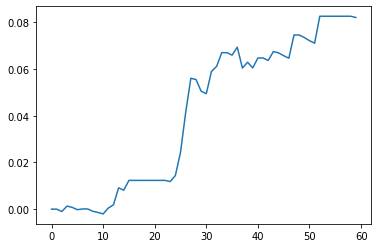

In [31]:
tmp = np.array([n for n in df_eptrain["wallet_value"]])
plt.plot((tmp[:60]/10000) -1)

<ipython-input-32-ff843ce41ac3>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp = [np.fromstring(n[1:-1], dtype=np.float, sep=' ')  for n in df_eptrain["reward"]]


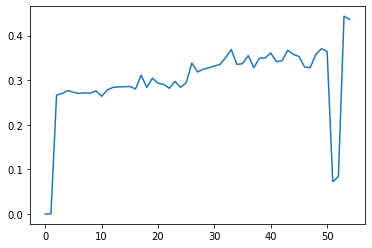

In [32]:
# tmp = [ast.literal_eval(n) for n in df_eptrain["reward"]]
tmp = [np.fromstring(n[1:-1], dtype=np.float, sep=' ')  for n in df_eptrain["reward"]]

# np.fromstring(s[1:-1], dtype=np.int, sep=' ')
plt.plot(tmp[:55])

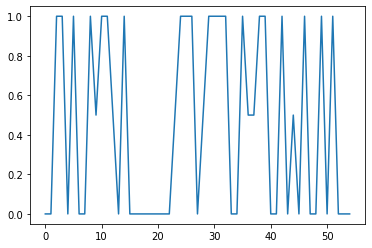

In [33]:
tmp = [ast.literal_eval(n) for n in df_eptrain["action"]]
plt.plot(tmp[:55])

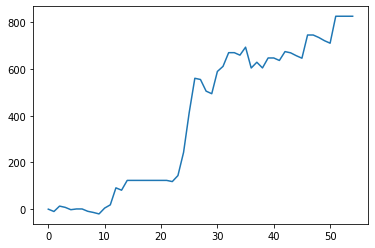

In [38]:
# tmp = [ast.literal_eval(n)[0] for n in df_train["reward"]]
tmp = df_train["profit"]

plt.plot(tmp[:55])

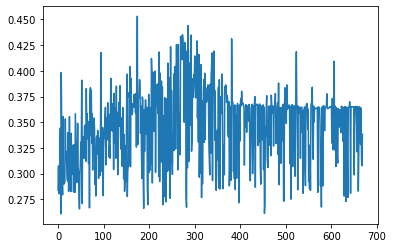

In [28]:
plact = [np.max(x)  if np.size(x) else 0 for x in act]
plt.plot(plact)

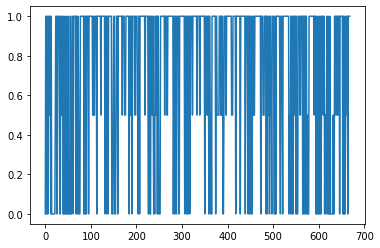

In [25]:
#  act, 
plt.plot(dqn)

In [21]:
act[:10]

[array([0.22592929, 0.20911834, 0.28103572, 0.2839167 ], dtype=float32),
 array([0.1849227 , 0.21249183, 0.30743429, 0.29515118]),
 array([0.2342655 , 0.20758751, 0.28033906, 0.27780783], dtype=float32),
 array([0.24526666, 0.2084129 , 0.263429  , 0.28289145], dtype=float32),
 array([0.21151558, 0.17826662, 0.32194796, 0.28826984]),
 array([0.24484575, 0.21185146, 0.19900457, 0.34429821]),
 array([0.26076016, 0.2553546 , 0.25154691, 0.23233833]),
 array([0.25077193, 0.17945871, 0.39838321, 0.17138615]),
 array([0.26991558, 0.3489474 , 0.20666611, 0.17447091]),
 array([0.21208698, 0.23717577, 0.29322923, 0.25750802])]

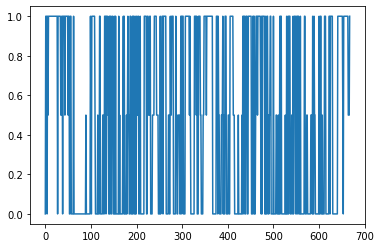

In [75]:
test = []
for i in range(1,len(dqn)):
    tmp = transform_to_dqn_action(act[i-1], dqn[i])
    test.append(tmp)
    
plt.plot(test)

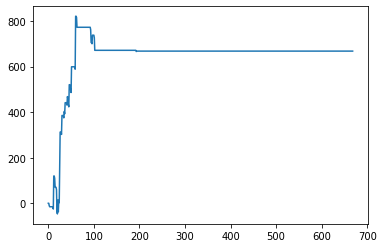

In [15]:
plt.plot(df_train["profit"])

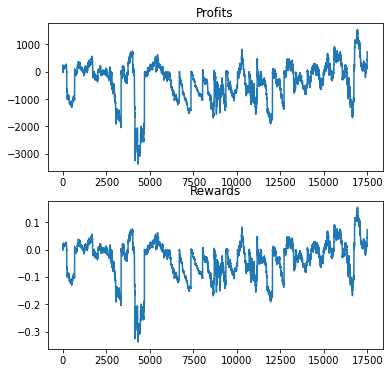

In [9]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(df.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in df.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

In [8]:
# Plot profit  
train_folder = './../data/20230328_175512/DQN_trial_0/'
print(len(hpo_list))
training_folders.append(train_folder)
df = pd.read_csv(f'{train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

8
(17495, 10)
5163.983486413956
